# LR構造解析（Adult / Census Income）

## 目的

Logistic Regression を適用し、
係数・予測確率・診断量（残差／leverage／Cook）に基づいて、
線形分類モデルの構造および挙動を解析する

## 目次

1. データ読み込み・前処理・モデル学習
2. CV評価（AUC）
3. 予測・評価可視化（予測確率ヒストグラム、ROC Curve、Confusion Matrix）
4. 係数（coef）解析
5. 診断量解析（residual、leverage、Cook）
6. 構造解釈・考察

## 1. データ読み込み・前処理・モデル学習

In [1]:
## 1. データ読み込み、前処理、モデル学習

import sys
from pathlib import Path

# --- プロジェクトルート自動検出 ---
ROOT = Path.cwd()
while not (ROOT / "data").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

# --- imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

from src.lr import preprocess, train_model, compute_diagnostics_logistic

# --- paths ---
RAW_TRAIN = ROOT / "data/raw/adult.data"

# --- 再現性 ---
torch.manual_seed(42)
np.random.seed(42)

# --- 列名 ---
COLS = [
    "age","workclass","fnlwgt","education","education-num","marital-status","occupation",
    "relationship","race","sex","capital-gain","capital-loss","hours-per-week",
    "native-country","income"
]

NUM_COLS = ["age","education-num","capital-gain","capital-loss","hours-per-week"]

# --- preprocess（欠損補完＋one-hotまで） ---
X_train, y_train, feature_names = preprocess(RAW_TRAIN)

y_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else np.asarray(y_train)
y_np = y_np.astype(int)

print("ROOT:", ROOT)
print("train exists:", RAW_TRAIN.exists())
print("X shape:", X_train.shape)

# --- scaling（学習を通すための標準化） ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --- model fit ---
model = train_model(X_train_scaled, y_train)

ROOT: K:\projects\adult-income-pca-ls-fe
train exists: True
X shape: (32561, 104)


## 2.CV評価（AUC）

Logistic Regression（線形分類モデル）が
目的変数 income をどの程度説明可能かを確認するため、
StratifiedKFold による交差検証（CV）を実施する。

評価指標には ROC AUC を用い、
クラス不均衡の影響を受けにくい判別性能の指標として採用する。
ここでは fold ごとのばらつきではなく、
モデルの安定性と線形近似の説明力を把握することを目的とする。

In [2]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []
for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_np), 1):
    X_tr, y_tr = X_train.iloc[tr_idx], y_np[tr_idx]
    X_va, y_va = X_train.iloc[va_idx], y_np[va_idx]

    scaler = StandardScaler()
    X_tr_sc = scaler.fit_transform(X_tr)
    X_va_sc = scaler.transform(X_va)

    model = train_model(X_tr_sc, y_tr)  # ← セクション1と同じ責務
    p_va = model.predict_proba(X_va_sc)[:, 1]  # ← ここは素直にsklearnでOK

    auc = roc_auc_score(y_va, p_va)
    aucs.append(auc)
    print(f"fold {fold}: AUC = {auc:.6f}")

print("-" * 40)
print(f"CV AUC mean = {np.mean(aucs):.6f}")
print(f"std         = {np.std(aucs):.6f}")


fold 5: AUC = 0.906221
----------------------------------------
CV AUC mean = 0.904968
std         = 0.002079


Logistic Regression（LS）のCV評価では AUC mean = 0.905 (std = 0.002)、
LightGBM（LGBM）のCV評価では AUC mean = 0.922 (std = 0.001) となった。

Logistic Regression によって Adult Income の大部分は説明可能である一方、
LGBM による性能差（ΔAUC ≈ 0.017）が観測された。
この差は、線形境界では取り切れない構造、非線形関係、
および特徴量間相互作用の存在を示唆する結果と解釈できる。

なお、本検証ではハイパーパラメータ最適化を行っていないため、
本結果は厳密な性能優劣の結論を目的とするものではない。
モデル優劣の判定ではなく、線形仮定と非線形許容の挙動差の観測として位置付ける。

本ノートにおけるCV比較は性能競争ではなく、
線形モデルの説明可能範囲および非線形モデルとの差分構造を把握するための参照情報である。

## 3.予測・評価可視化ブロック（予測確率ヒストグラム、ROC Curve、Confusion Matrix）

セクション3では、学習済み Logistic Regression モデルを用いて、モデルの予測挙動を補助的に可視化する。
具体的には、predict_proba による各サンプルの正例確率をヒストグラムで確認し、モデルが確率空間をどのように分布させているかを見る。

さらに、ROC Curve によって分類能力を定量的に把握し、AUC を指標として全体性能を確認する。
最適閾値 0.25 に基づく Confusion Matrix（割合表示）や、正しく分類できたサンプルと誤分類サンプルのインデックス別散布図を併用することで、誤分類の位置やパターンを直感的に把握できる。

これらの可視化は、係数解析や診断量解析で得られた構造理解を補助的に確認する手段として有用であり、モデルの予測精度・分類挙動の全体像と構造理解を統合的に評価することができる。

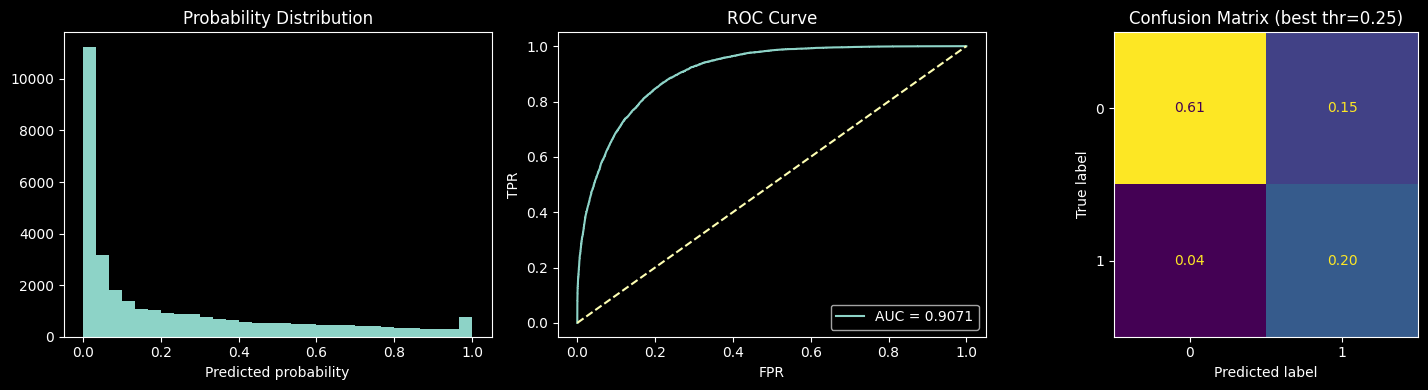

In [3]:
del auc
from sklearn.metrics import auc

# 予測確率と正解ラベル
p = model.predict_proba(X_train_scaled)[:, 1]
y_true = y_train  # 既に整数化済み

# =====================
# ROC計算
# =====================
fpr, tpr, thresholds = roc_curve(y_true, p)
roc_auc = auc(fpr, tpr)

# =====================
# 最適閾値（左上に最も近い点）
# =====================
dist = (fpr**2 + (1 - tpr)**2)**0.5
best_idx = dist.argmin()
best_thr = thresholds[best_idx]

# =====================
# Confusion Matrix計算
# =====================
y_pred = (p >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)

# =====================
# 1セル3図
# =====================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) Probability Distribution
axes[0].hist(p, bins=30)
axes[0].set_title("Probability Distribution")
axes[0].set_xlabel("Predicted probability")

# 2) ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
axes[1].plot([0, 1], [0, 1], linestyle="--")
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].legend()

# 3) Confusion Matrix（最適閾値）
cm_norm = cm / cm.sum()  # 全体で1に
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0,1])
disp.plot(ax=axes[2], values_format=".2f", colorbar=False)
axes[2].set_title(f"Confusion Matrix (best thr={best_thr:.2f})")

plt.tight_layout()
plt.show()


セクション3では、学習済み Logistic Regression モデルの予測挙動を可視化して、構造解析の理解を補助する。

予測確率のヒストグラムを見ると、大半のサンプルは低確率側に集中しており、正例は少数派であることが直感的に確認できる。

ROC Curve の AUC は 0.907 で、モデルが概ね正しく分類していることを示す。

最適閾値 0.25 に基づく Confusion Matrix（割合表示）では、全体の約 81% のサンプルが正しく分類され、誤分類のバランスも直感的に把握できる。

これにより、係数解析や診断量解析で明らかになった入力データ構造の理解と、モデルの予測挙動の全体像を統合的に評価することができる。

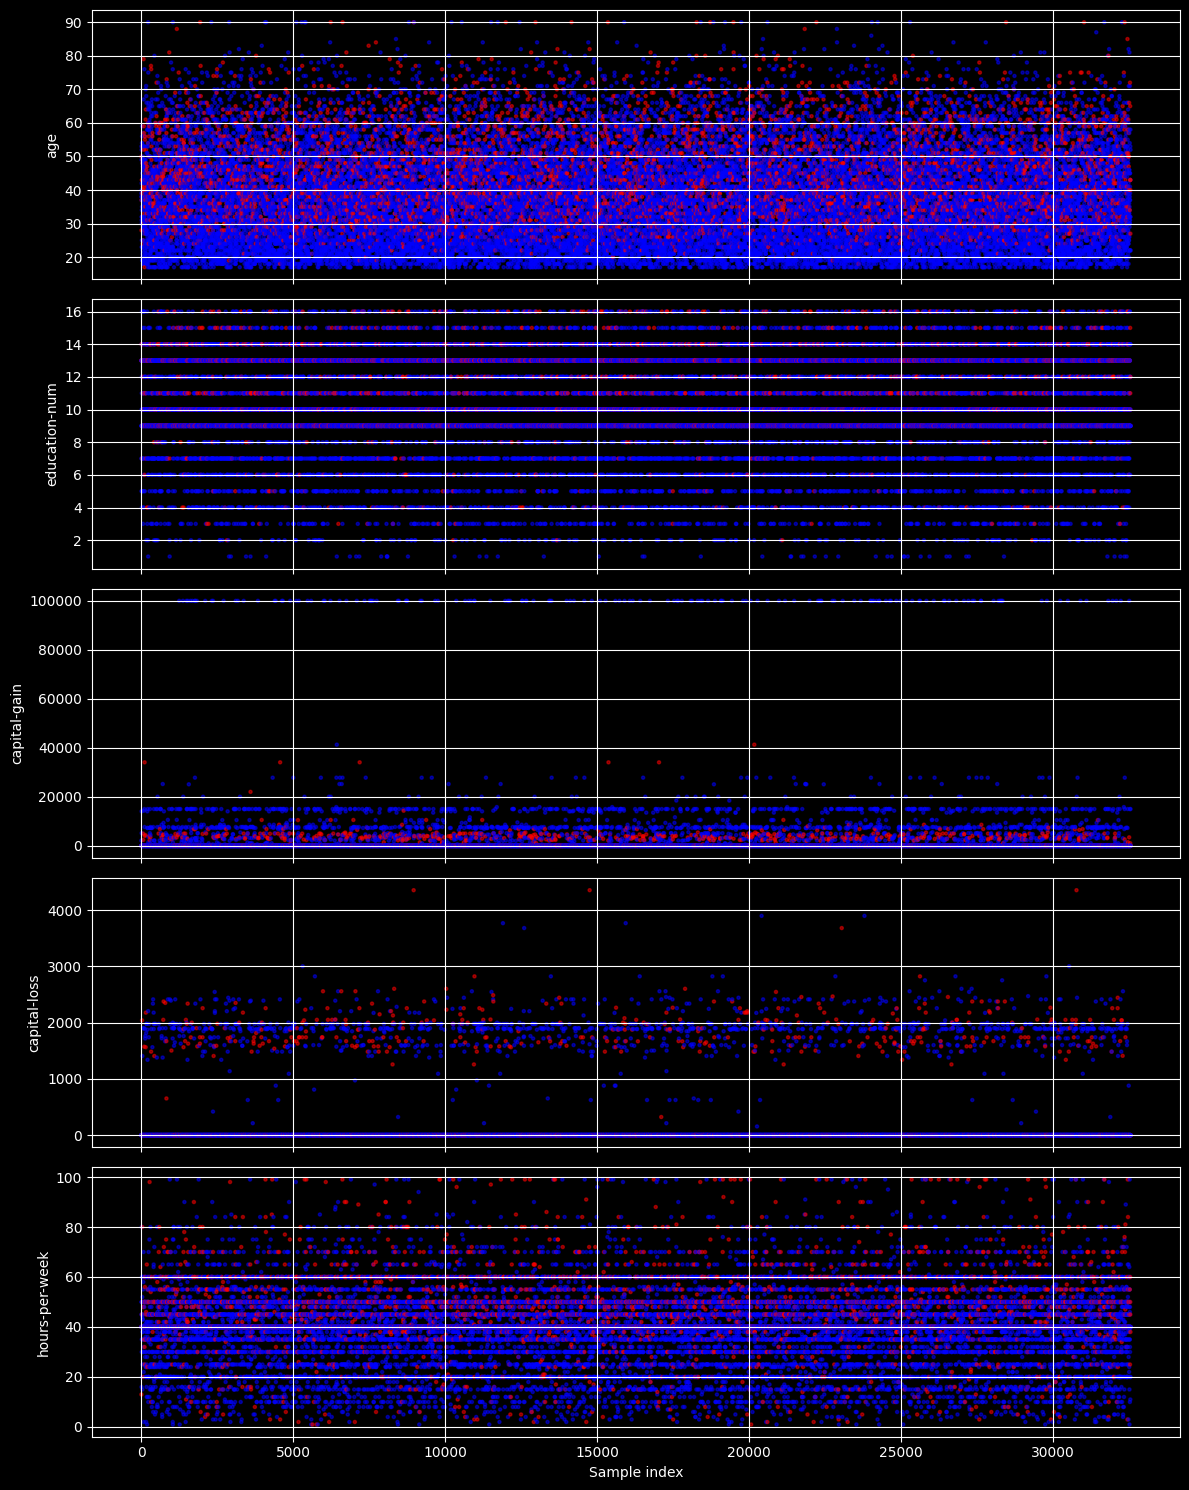

In [17]:
# ==============================
# NUM_COLS インデックス散布図（正誤色分け）
# ==============================

# 予測確率・閾値による予測ラベル
threshold = 0.25
p = model.predict_proba(X_train_scaled)[:, 1]
y_pred = (p >= threshold).astype(int)

# 正しく分類されたかどうか（1=正解, 0=誤分類）
correct = (y_pred == y_np).astype(int)

# DataFrame化（X_trainがDataFrameでない場合）
X_num = X_train[NUM_COLS] if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=NUM_COLS)

# 図の作成
fig, axes = plt.subplots(len(NUM_COLS), 1, figsize=(12, 3*len(NUM_COLS)), sharex=True)

for i, col in enumerate(NUM_COLS):
    axes[i].scatter(
        X_num.index,        # サンプルインデックス
        X_num[col],         # 特徴量値
        c=correct,          # 正誤で色分け
        cmap='bwr_r',       # 青=正解, 赤=誤分類
        s=5,                # 点サイズ小さめ
        alpha=0.5           # 重なり調整
    )
    axes[i].set_ylabel(col)
    axes[i].grid(True)

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()


1. 全体傾向

- 青が多数、赤が少数 → 分類率約81%と一致
- 赤は誤分類サンプルで、全体の分布に散在している

2. 各特徴量との関係

- age
    - 青が全体に広く分布
    - 赤も年齢に偏りなく散在 → 年齢だけでは誤分類の傾向は弱そう

- education-num
    - 青が多数派だが、赤は中〜高学歴の一部に点在
    - 一部の正例を誤分類していることが確認できる

- capital-gain
    - 高額の外れ値に赤が少し目立つ
    - 正例の多くは低額だが、外れ値の影響で誤分類が生じている可能性

- capital-loss
    - 赤と青が混在しているが、極端値は少数
    - 判別への影響は弱い印象

- hours-per-week
    - 青が多く、赤は長時間労働側に少し点在
    - 高労働時間サンプルの一部が誤分類されやすい
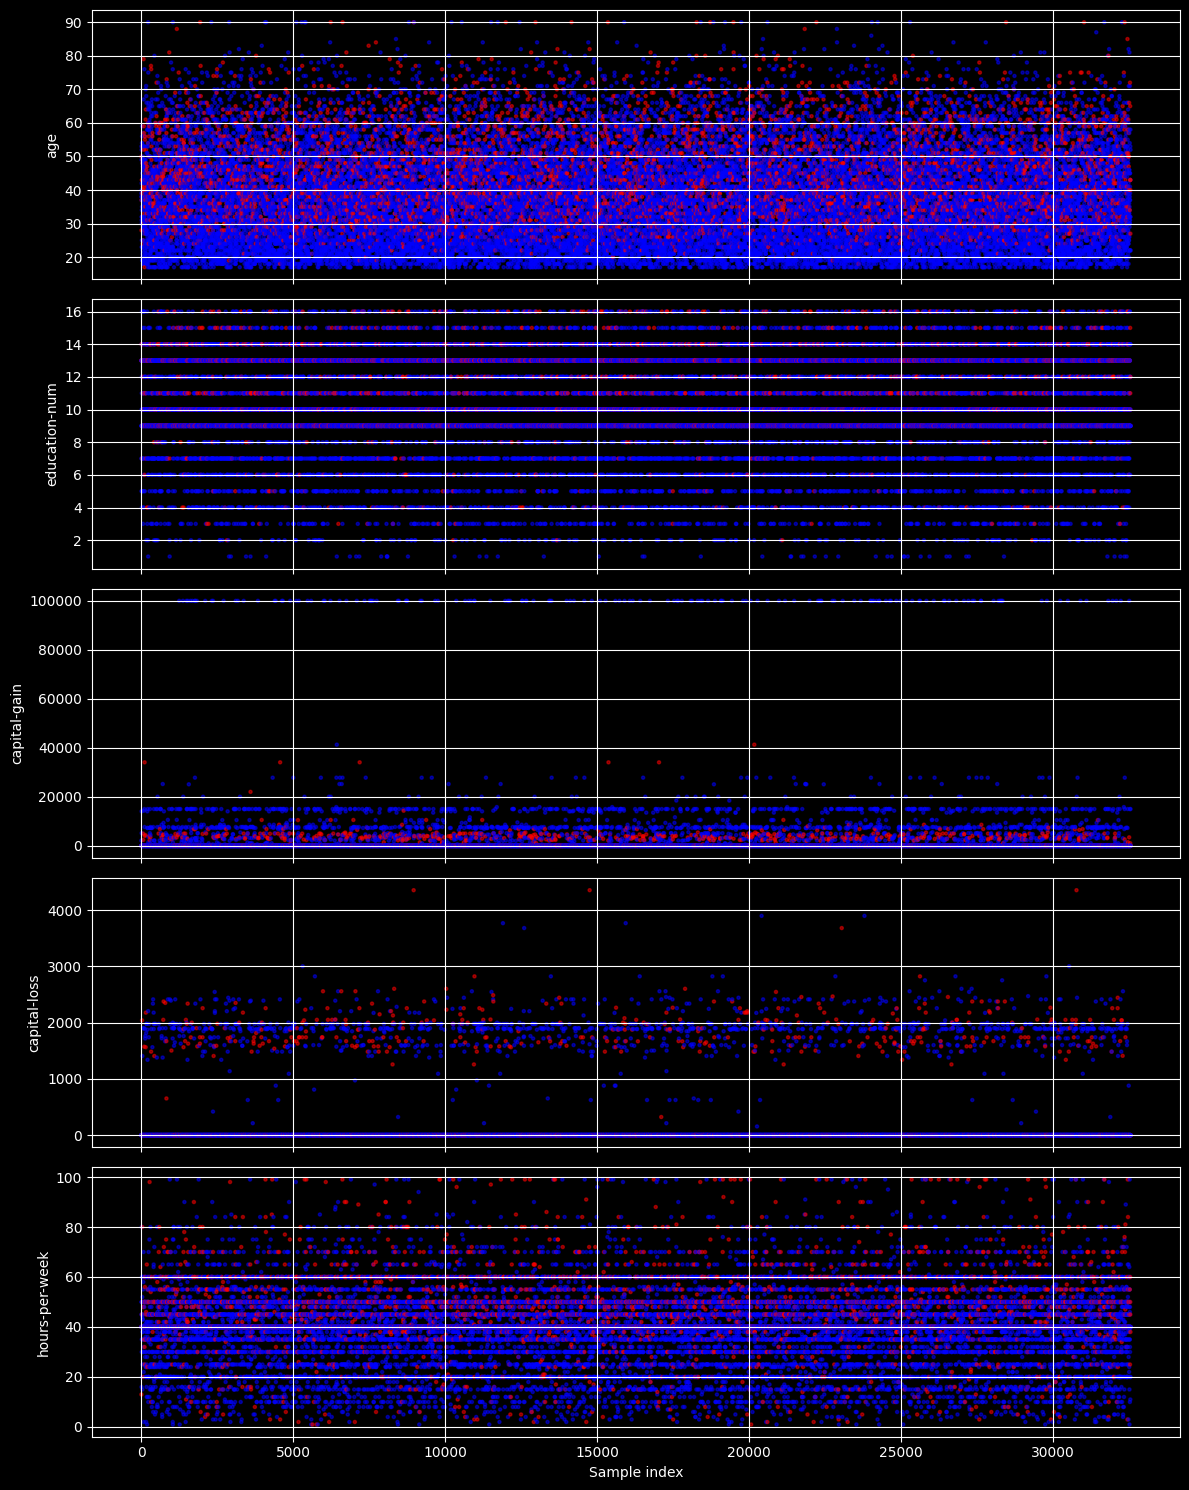

総合解釈

- 誤分類（赤）は全体の一部に散在し、多数サンプルは安定して正しく分類されている
- capital-gain の極端値や education-num、hours-per-week の値域で誤分類が発生しやすい
- この図は 係数解析の補助として、どの値域・特徴量で誤分類が出やすいかを直感的に把握する のに有用
- FEで注意すべき値域や、誤分類が起きやすい特徴量の範囲を確認できる

## 4. 係数（coef）解析

Logistic Regression における係数は、各特徴量が目的変数（Income >50K）の対数オッズに与える影響を表す。

係数の符号は影響方向を示し、

- 正の係数は高所得側への寄与、

- 負の係数は低所得側への寄与

を意味する。

また、特徴量が標準化されている場合、係数の絶対値は影響の相対的な強さの指標として解釈できる。
したがって、本解析では標準化済み特徴量に基づき、係数の大小関係を比較する。

以下では、係数ランキングを確認した後、主要特徴量の寄与構造および特徴量分布との関係を検討する。


### 4.1 係数ランキング

標準化済み特徴量に基づき、Logistic Regression の係数を算出し、
その絶対値でソートした。

係数の絶対値は、各特徴量が対数オッズ推定へ与える影響の
相対的な強さを表す指標として解釈できる。
絶対値が大きい特徴量ほど、モデルの判別境界形成に
強く関与していることを意味する。

以下に、係数の大きい特徴量を確認する。

In [4]:
# --- coef 取得 ---
coef = model.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef
})

coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

coef_df.head(20)


,feature,coef,abs_coef
0,capital-gain,2.369197,2.369197
1,marital-status_Married-civ-spouse,0.737401,0.737401
2,education_Preschool,-0.542018,0.542018
3,marital-status_Never-married,-0.509156,0.509156
4,education-num,0.391563,0.391563
5,hours-per-week,0.376800,0.376800
6,age,0.312555,0.312555
7,relationship_Own-child,-0.306367,0.306367
8,capital-loss,0.258429,0.258429
9,relationship_Wife,0.252896,0.252896


係数ランキングの結果、capital-gain が他の特徴量と比較して
突出して大きな係数を示した。

次いで marital-status、education、education-num、
hours-per-week、age などが上位に位置しており、
社会属性および労働関連特徴量が判別境界形成へ
寄与している構造が確認された。

また、sex_Male / sex_Female の係数は符号が対称であり、
one-hot encoding による相補的関係が反映された結果と解釈される。

特に capital-gain の係数が顕著であった点については、
特徴量分布の偏りや値域構造の影響が考えられるため、
次節で分布特性を確認する

### 4.2 特徴量分布の確認

NUM_COLS の各特徴量について、まずヒストグラムで値の分布を確認し、その後、サンプルインデックスごとに散布して目的変数で色分けする。

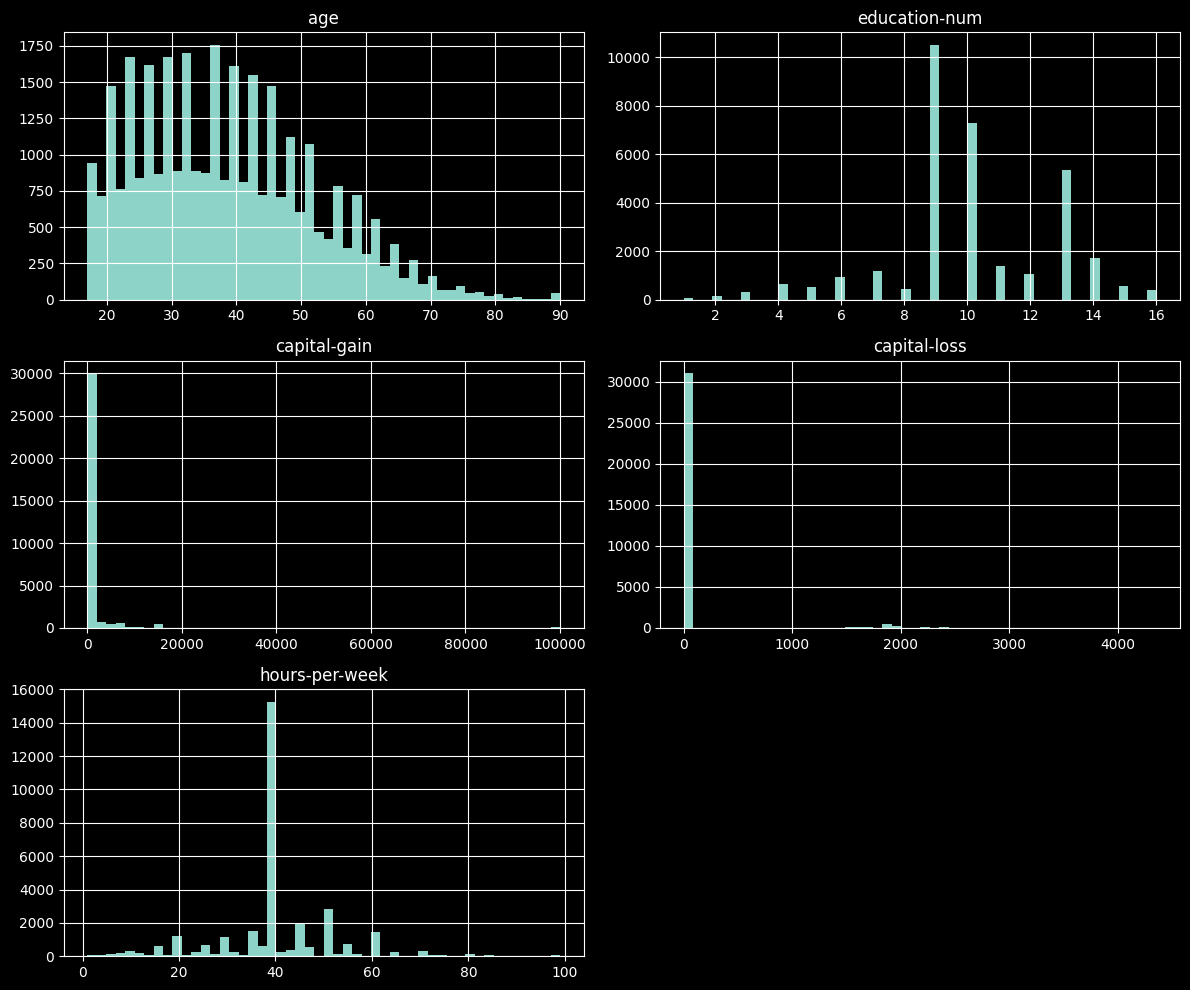

In [5]:
X_train[NUM_COLS].hist(
    figsize=(12, 10),
    bins=50
)
plt.tight_layout()
plt.show()


主要特徴量の分布を確認した結果、特徴量ごとに明確な分布特性の違いが観測された。

capital-gain および capital-loss は、
ゼロ値が大部分を占め、一部サンプルで大きな値を示す
強いロングテール分布を示した。
このような分布構造は、係数推定に強い影響を与える特徴量特性である。

hours-per-week は特定値（40付近）への集中が見られ、
離散的かつ非対称な分布を示した。

education-num は典型的な離散分布を示し、
カテゴリ的性質を持つ特徴量としての挙動が確認された。

age は右裾を持つ非対称分布を示した。

これらの結果より、係数ランキングで観測された
突出係数や寄与構造は、
特徴量分布の偏りおよび値域構造と整合的な挙動と解釈される。


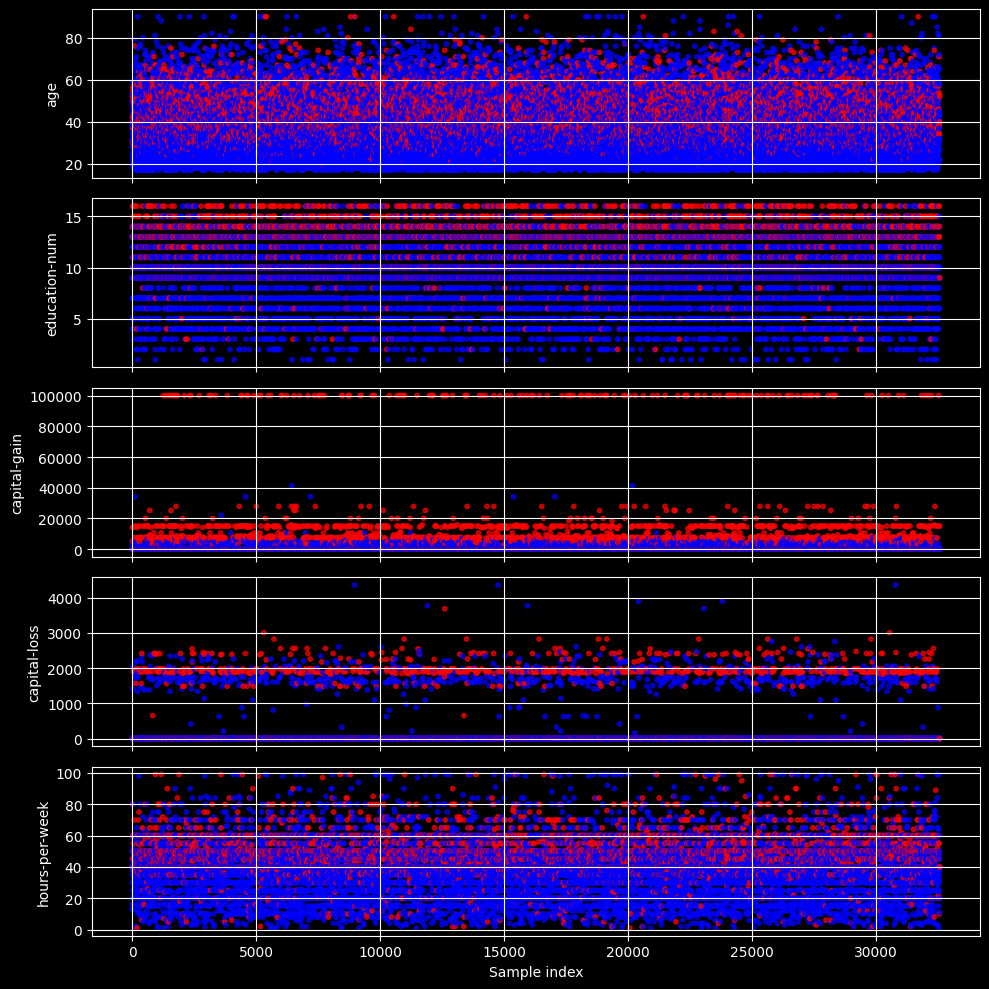

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# NUM_COLS のサンプルデータ
NUM_COLS = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

# X_train が DataFrame の場合
X_num = X_train[NUM_COLS] if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=NUM_COLS)
y = y_train.values if isinstance(y_train, pd.Series) else np.asarray(y_train)

# インデックスごとに特徴量を散布図で表示
fig, axes = plt.subplots(len(NUM_COLS), 1, figsize=(10, 2*len(NUM_COLS)), sharex=True)

for i, col in enumerate(NUM_COLS):
    axes[i].scatter(X_num.index, X_num[col], c=y, cmap='bwr', s=10, alpha=0.7)
    axes[i].set_ylabel(col)
    axes[i].grid(True)

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()

1. age

- 赤（正例）が広く散在しているが、高齢になるほど赤がやや目立つ傾向
- 中央付近の青（負例）が多く、正例は少数派

2. education-num

- 高学歴（値が大きい）サンプルに赤が多く分布
- 赤/青の差が比較的明確で、正例は学歴が高い傾向

3. capital-gain

- 赤（正例）が 高額キャピタルゲインの極端値に集中
- ほとんどのサンプルは0付近（青）
- 極端値が正例の判別に寄与している様子が見える

4. capital-loss

- 赤は高値でも少数
- 正例との明確な傾向は薄い
- 分布はほとんど0付近で、正例/負例の差は小さい

5. hours-per-week

- 赤は比較的長時間労働側に散在
- 中央付近の青が多く、長時間労働が正例に関連する可能性 がある

総合的な分析

- 正例に強く関係しそうな特徴量
→ education-num, capital-gain, hours-per-week

- 分布的に影響が薄そうな特徴量
→ capital-loss, age（中間層が多い）

- 極端値の役割
→ capital-gain のように、少数の極端値が正例に強く対応している

### 4.3　係数構造と特徴量特性の統合解釈

係数ランキングおよび4.2の特徴量分布・インデックス別散布図の確認を通じて、Logistic Regression における判別構造の特徴が明確となった。

- capital-gain は突出した係数を示し、モデルの対数オッズ推定に強く影響していた。対応する分布はゼロ値への集中とロングテール構造を示しており、散布図でも正例が極端値に集まっている様子が確認できる。

- marital-status、education、education-num、hours-per-week、age などは安定して上位に位置し、社会属性および労働関連特徴量が補完的に判別境界形成に寄与している構造が散布図からも確認できる。

- sex に関する係数は符号対称を示し、one-hot encoding による相補関係が適切に反映されている。

以上より、本モデルの係数構造は 単一特徴量による決定ではなく、「分離性の高い特徴量」と「広範な社会属性特徴量」による複合的な判別構造と解釈できる

## 5. 診断量解析（residual、leverage、Cook）

係数解析に続き、モデルの予測挙動および推定構造を補助的に評価するため、
診断量を確認する。

診断量は、各サンプルに対するモデル適合の程度、
および当該サンプルが推定へ与える影響を評価する指標である。
予測精度指標とは異なり、
モデルの安定性や影響構造を把握する目的で用いられる。

本節では residual、leverage、Cook’s distance を対象とし、
分布特性および指標間の関係を確認する。

### 5.1 診断量の分布と関係

residual、leverage、Cook’s distance の分布を確認し、
診断量の全体構造を把握する。

あわせて、診断量間の関係（Residual–Cook、Leverage–Cook）
を散布図により確認し、
高影響サンプルの有無および影響構造の傾向を観察する。

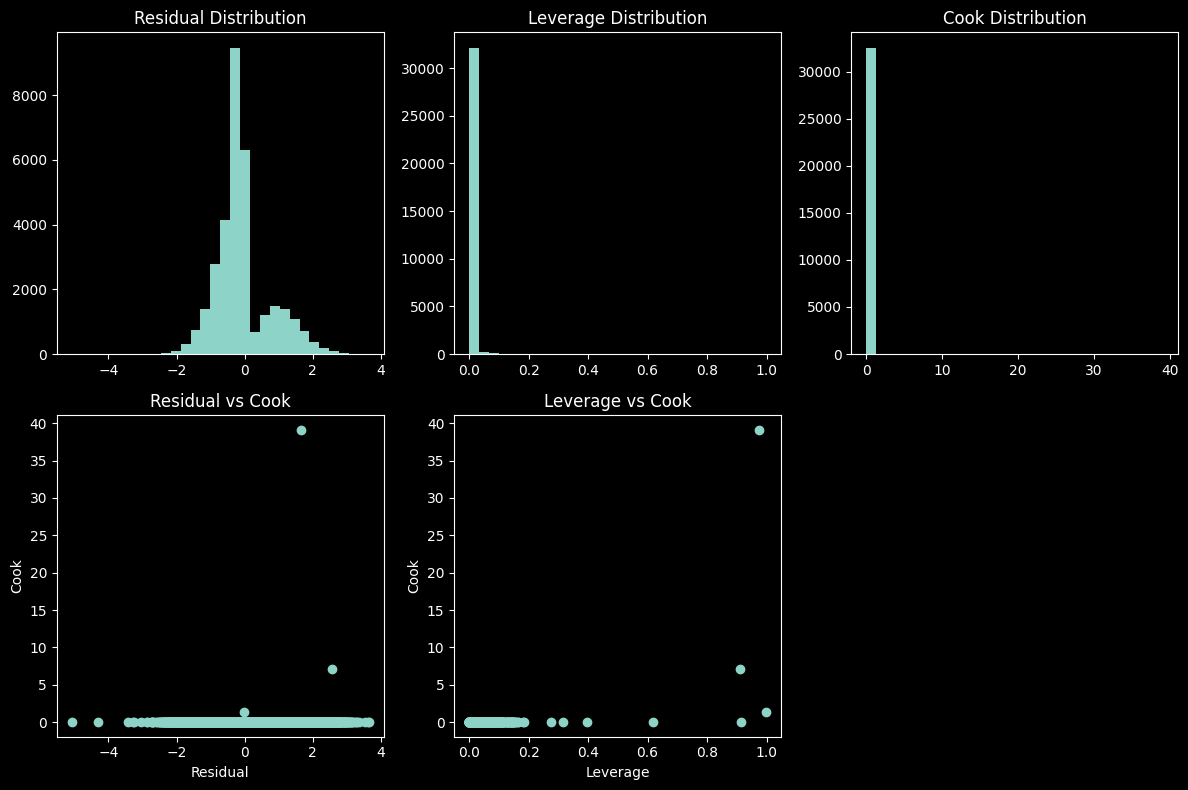

In [6]:
diag = compute_diagnostics_logistic(model, X_train_scaled, y_train)

r = diag["r_dev"]
h = diag["leverage"]
c = diag["cook"]

#2行×3列のサブプロットを作成
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# ===== ヒスト =====
axes[0, 0].hist(r, bins=30)
axes[0, 0].set_title("Residual Distribution")

axes[0, 1].hist(h, bins=30)
axes[0, 1].set_title("Leverage Distribution")

axes[0, 2].hist(c, bins=30)
axes[0, 2].set_title("Cook Distribution")

# ===== 相関系 =====
axes[1, 0].scatter(r, c)
axes[1, 0].set_xlabel("Residual")
axes[1, 0].set_ylabel("Cook")
axes[1, 0].set_title("Residual vs Cook")

axes[1, 1].scatter(h, c)
axes[1, 1].set_xlabel("Leverage")
axes[1, 1].set_ylabel("Cook")
axes[1, 1].set_title("Leverage vs Cook")

# 空き（見た目調整用）
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


診断量の分布を確認した結果、Residual、Leverage、Cook’s distance に
特徴的な構造が観測された。

Residual 分布は概ね中心付近に集中しつつも、
左右に裾を持つ分布形状を示した。
大部分のサンプルはモデルに良好に適合している一方、
一部に大きな残差を持つサンプルが存在する。

Leverage 分布は低値領域への強い集中を示し、
大多数のサンプルは平均的な影響度に留まっている。
ただし、ごく一部に高 leverage サンプルが確認された。

Cook’s distance 分布も低値に集中しており、
モデル全体の安定性は概ね維持されていると解釈できる。
一方で、散布図より、少数ながら Cook’s distance が突出した
サンプルが存在することが確認された。

これらのサンプルは、
「残差が大きい」または「leverage が高い」特性を持ち、
モデル推定へ相対的に強い影響を与えている可能性がある。

以上より、本モデルは大部分のデータに対して安定であるが、
一部の影響度の高いサンプルが存在する構造を持つことが示唆された。


### 5.2 高影響サンプルの確認

Cook’s distance の大きいサンプルを抽出し、
高影響サンプルの存在を確認する。

特に Cook および leverage が突出したサンプルについて、
特徴量値を参照し、
影響度増大の要因および特徴量空間上の位置特性を検討する。

In [7]:
# 高影響サンプルの確認
diag_df = pd.DataFrame(diag)
diag_df.sort_values("cook", ascending=False).head()

,p,r_dev,leverage,cook
52,0.256272,1.650160,0.974469,39.143985
25799,0.036388,2.574306,0.909826,7.129963
19609,0.000264,-0.022993,0.998099,1.404461
32304,0.002644,-0.072769,0.915122,0.006468
18482,0.164218,1.900820,0.137379,0.006414


In [8]:
# 高い影響量サンプルの特徴量
train_df = pd.read_csv(
    RAW_TRAIN,
    names=COLS,
    na_values="?",
    skipinitialspace=True
)
idx = 52
train_df.iloc[idx]

age                               47
workclass                    Private
fnlwgt                         51835
education                Prof-school
education-num                     15
marital-status    Married-civ-spouse
occupation            Prof-specialty
relationship                    Wife
race                           White
sex                           Female
capital-gain                       0
capital-loss                    1902
hours-per-week                    60
native-country              Honduras
income                          >50K
Name: 52, dtype: object

サンプル index 52 は Cook距離が 39.14 と圧倒的に大きく、モデルに対する影響が極めて強い。特徴量を見ると、年齢は 47、学歴は Prof-school（education-num 15）、勤務時間は 60時間/週 で、capital-loss が 1902 と突出している。

Leverageも高く、説明変数空間の端に位置していることがわかる。Residual は中程度であるため、このサンプルは極端値が係数構造に大きく影響している典型例といえる。FE への直接利用はせず、尾やrare pattern の示唆材料として観察するのが適切である。

## 6. 構造解釈・考察

今回の Logistic Regression による Adult Income モデル構造解析の結果、以下の点が確認された。

1. モデル全体像と予測挙動
    - 予測確率は 0 側への偏りが見られ、正例は少数派として分布する。
    - ROC Curve による AUC ≈ 0.907 を示し、ベースラインとして概ね良好な識別性能を持つ。
    - 判定閾値 0.25 を採用することで FN を抑制しつつ、分類バランスの調整が可能であることが確認された。
    - 閾値 0.25 に基づく Confusion Matrix（割合表示）では、全体の約 81% が正しく分類され、誤分類は特定領域への集中ではなく散在的に観察された。
    - これらの可視化は構造解析結果そのものではなく、モデルの予測挙動および分類傾向を直感的に把握するための補助的手段である。

2. 主要特徴量の寄与構造
    - capital-gain が最大の寄与を示し、判別構造を強く支配している。対応する分布はゼロ集中とロングテールを示し、少数の極端値が係数推定へ影響している。
    - marital-status_Married-civ-spouse, education-num, hours-per-week, age などが中程度の寄与を持ち、多数サンプルにわたり補完的に判別境界形成へ寄与する。
    - 負の寄与は education_Preschool, marital-status_Never-married などに観察され、極端属性または少数群に対応している。
    - 以上より、モデルは単一特徴量依存ではなく、分離性の高い変数と広範な社会属性変数による複合的判別構造を形成していると解釈される。

3. 診断量から見た高影響サンプル
    - Cook 距離では index 52 が突出（39.14）、leverage 0.974 と極端値を示した。
    - 当該サンプルは capital-loss=1902, hours-per-week=60, education=Prof-school 等の特徴を持ち、残差は中程度である。
    - この観測は係数構造へ強い影響を与えるが、母集団内では稀なケースであり、FE直接適用対象ではなく、構造理解および分布尾部観察の文脈で扱うのが妥当である。

4. 総合的考察
    - Adult Income データでは、少数の極端値および稀なパターンが係数推定に影響する構造が確認された。
    - 一方、多数派サンプルはモデル安定性の基盤として機能する。
    - 診断量は高影響観測を特定する補助指標であり、モデル全体の構造把握は係数解析を主軸とする。
    - 本構造理解は、今後の Feature Engineering、閾値設計、非線形モデル（LGBM）との比較検討に対する基礎情報を与える。